# Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import glob
import os
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Define the root folder path in Google Drive
root_folder = '/content/drive/My Drive/Fraud Data/'

# Find all CSV files in all subfolders
file_paths = glob.glob(root_folder + '**/*.csv', recursive=True)

# Load all found CSV files into a dictionary of DataFrames
dataframes = {}
for file_path in file_paths:
    # Extract a unique name based on folder and file name
    file_name = "_".join(file_path.split('/')[-2:]).replace('.csv', '')
    try:
        dataframes[file_name] = pd.read_csv(file_path)
        print(f"Loaded: {file_name}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")


Loaded: Customer Profiles_account_activity
Loaded: Customer Profiles_customer_data
Loaded: Transaction Data_transaction_metadata
Loaded: Transaction Data_transaction_records
Loaded: Merchant Information_merchant_data
Loaded: Merchant Information_transaction_category_labels
Loaded: Fraudulent Patterns_suspicious_activity
Loaded: Fraudulent Patterns_fraud_indicators
Loaded: Transaction Amounts_amount_data
Loaded: Transaction Amounts_anomaly_scores


# Data Overview

In [ ]:
# Display the first few rows of each DataFrame
for name, df in dataframes.items():
    print(f"Dataset: {name}")
    print(df.head())
    print("-" * 50)

Dataset: Customer Profiles_account_activity
   CustomerID  AccountBalance   LastLogin
0        1001     9507.272060  2022-01-01
1        1002     7408.704536  2022-01-02
2        1003     1715.321989  2022-01-03
3        1004     3101.509134  2022-01-04
4        1005     5405.766914  2022-01-05
--------------------------------------------------
Dataset: Customer Profiles_customer_data
   CustomerID           Name  Age       Address
0        1001  Customer 1001   54  Address 1001
1        1002  Customer 1002   35  Address 1002
2        1003  Customer 1003   40  Address 1003
3        1004  Customer 1004   30  Address 1004
4        1005  Customer 1005   46  Address 1005
--------------------------------------------------
Dataset: Transaction Data_transaction_metadata
   TransactionID            Timestamp  MerchantID
0              1  2022-01-01 00:00:00        2701
1              2  2022-01-01 01:00:00        2070
2              3  2022-01-01 02:00:00        2238
3              4  2022-01-

In [ ]:
# Inspect dataframes details
for name, df in dataframes.items():
    print(f"Dataset: {name}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns}")
    print(df.info())
    print("-" * 50)

Dataset: Customer Profiles_account_activity
Shape: (1000, 3)
Columns: Index(['CustomerID', 'AccountBalance', 'LastLogin'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      1000 non-null   int64  
 1   AccountBalance  1000 non-null   float64
 2   LastLogin       1000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB
None
--------------------------------------------------
Dataset: Customer Profiles_customer_data
Shape: (1000, 4)
Columns: Index(['CustomerID', 'Name', 'Age', 'Address'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  1000 non-null   int64 
 1   Name        1000 non-null   object
 2   Age        

In [ ]:
# Check for Missing Values
for name, df in dataframes.items():
    print(f"Missing Values in {name}:")
    print(df.isnull().sum())
    print("-" * 50)

Missing Values in Customer Profiles_account_activity:
CustomerID        0
AccountBalance    0
LastLogin         0
dtype: int64
--------------------------------------------------
Missing Values in Customer Profiles_customer_data:
CustomerID    0
Name          0
Age           0
Address       0
dtype: int64
--------------------------------------------------
Missing Values in Transaction Data_transaction_metadata:
TransactionID    0
Timestamp        0
MerchantID       0
dtype: int64
--------------------------------------------------
Missing Values in Transaction Data_transaction_records:
TransactionID    0
Amount           0
CustomerID       0
dtype: int64
--------------------------------------------------
Missing Values in Merchant Information_merchant_data:
MerchantID      0
MerchantName    0
Location        0
dtype: int64
--------------------------------------------------
Missing Values in Merchant Information_transaction_category_labels:
TransactionID    0
Category         0
dtype: int

In [ ]:
# Basic Descriptive Statistics
for name, df in dataframes.items():
    print(f"Descriptive Stats for {name}:")
    print(df.describe())
    print("-" * 50)

Descriptive Stats for Customer Profiles_account_activity:
        CustomerID  AccountBalance
count  1000.000000     1000.000000
mean   1500.500000     5558.067698
std     288.819436     2596.890997
min    1001.000000     1009.248716
25%    1250.750000     3297.255763
50%    1500.500000     5569.672709
75%    1750.250000     7910.029699
max    2000.000000     9999.776239
--------------------------------------------------
Descriptive Stats for Customer Profiles_customer_data:
        CustomerID          Age
count  1000.000000  1000.000000
mean   1500.500000    39.892000
std     288.819436    13.524394
min    1001.000000    18.000000
25%    1250.750000    28.000000
50%    1500.500000    39.000000
75%    1750.250000    51.000000
max    2000.000000    64.000000
--------------------------------------------------
Descriptive Stats for Transaction Data_transaction_metadata:
       TransactionID   MerchantID
count    1000.000000  1000.000000
mean      500.500000  2504.701000
std       288.81943

# Data Cleaning

In [ ]:
# Remove Duplicates
for name, df in dataframes.items():
    duplicates = df.duplicated().sum()
    print(f"{duplicates} duplicate rows in {name}")
    dataframes[name] = df.drop_duplicates()

0 duplicate rows in Customer Profiles_account_activity
0 duplicate rows in Customer Profiles_customer_data
0 duplicate rows in Transaction Data_transaction_metadata
0 duplicate rows in Transaction Data_transaction_records
0 duplicate rows in Merchant Information_merchant_data
0 duplicate rows in Merchant Information_transaction_category_labels
0 duplicate rows in Fraudulent Patterns_suspicious_activity
0 duplicate rows in Fraudulent Patterns_fraud_indicators
0 duplicate rows in Transaction Amounts_amount_data
0 duplicate rows in Transaction Amounts_anomaly_scores


# Merge Datasets

In [ ]:
# Example: Merging necessary datasets from the loaded DataFrames
customer_data = pd.merge(dataframes['Customer Profiles_customer_data'],
                         dataframes['Customer Profiles_account_activity'],
                         on='CustomerID')

transaction_data = pd.merge(dataframes['Fraudulent Patterns_fraud_indicators'],
                            dataframes['Merchant Information_transaction_category_labels'],
                            on='TransactionID')

transaction_data = pd.merge(transaction_data,
                            dataframes['Transaction Amounts_amount_data'],
                            on='TransactionID')

transaction_data = pd.merge(transaction_data,
                            dataframes['Transaction Amounts_anomaly_scores'],
                            on='TransactionID')

transaction_data = pd.merge(transaction_data,
                            dataframes['Transaction Data_transaction_metadata'],
                            on='TransactionID')

transaction_data = pd.merge(transaction_data,
                            dataframes['Transaction Data_transaction_records'],
                            on='TransactionID')

# Final merge with customer data
data = pd.merge(transaction_data, customer_data, on='CustomerID')

# EDA

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionID      1000 non-null   int64  
 1   FraudIndicator     1000 non-null   int64  
 2   Category           1000 non-null   object 
 3   TransactionAmount  1000 non-null   float64
 4   AnomalyScore       1000 non-null   float64
 5   Timestamp          1000 non-null   object 
 6   MerchantID         1000 non-null   int64  
 7   Amount             1000 non-null   float64
 8   CustomerID         1000 non-null   int64  
 9   Name               1000 non-null   object 
 10  Age                1000 non-null   int64  
 11  Address            1000 non-null   object 
 12  AccountBalance     1000 non-null   float64
 13  LastLogin          1000 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 109.5+ KB
None

Summary Statistics:
       Transaction

<ipython-input-72-fab63b513f3a>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FraudIndicator', data=data, palette='Set2')


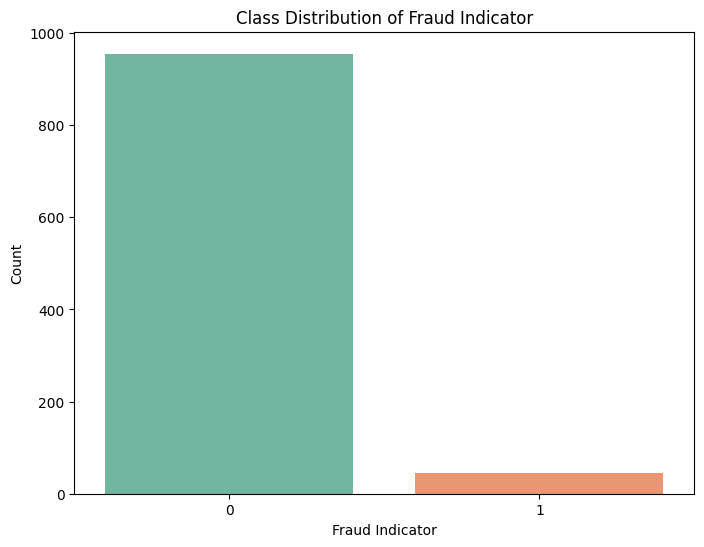

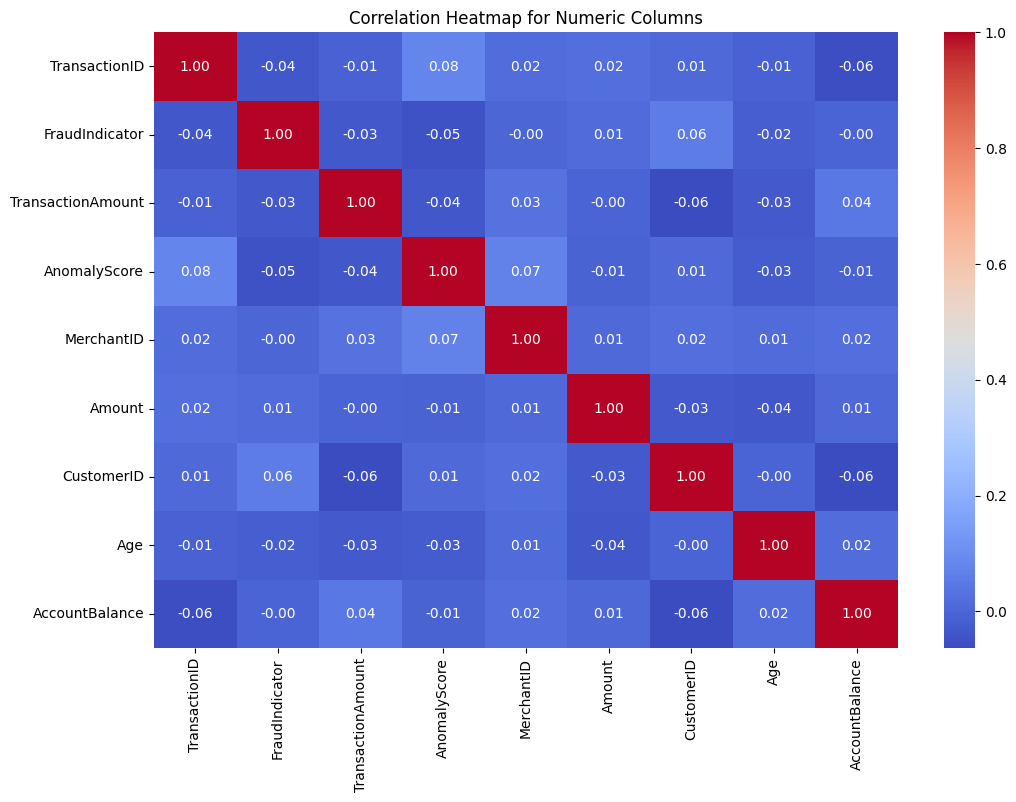

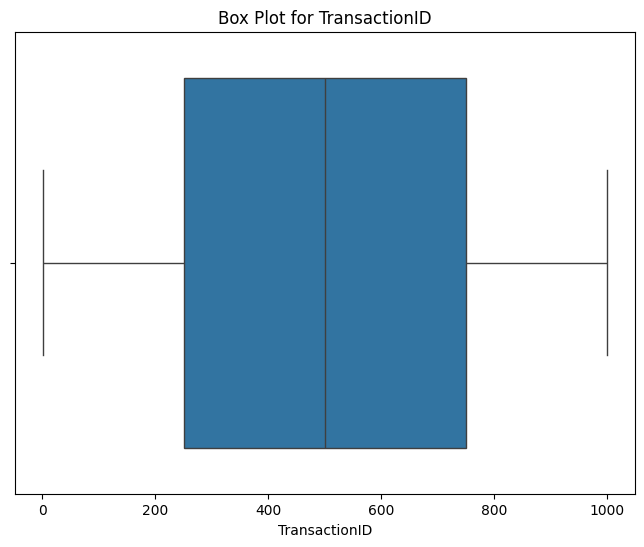

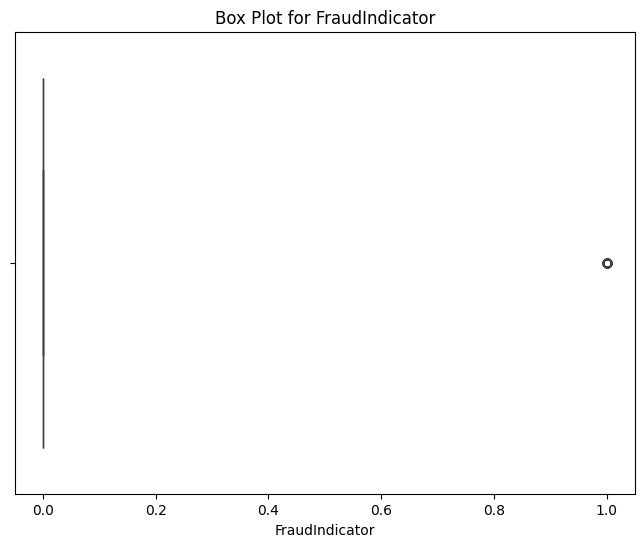

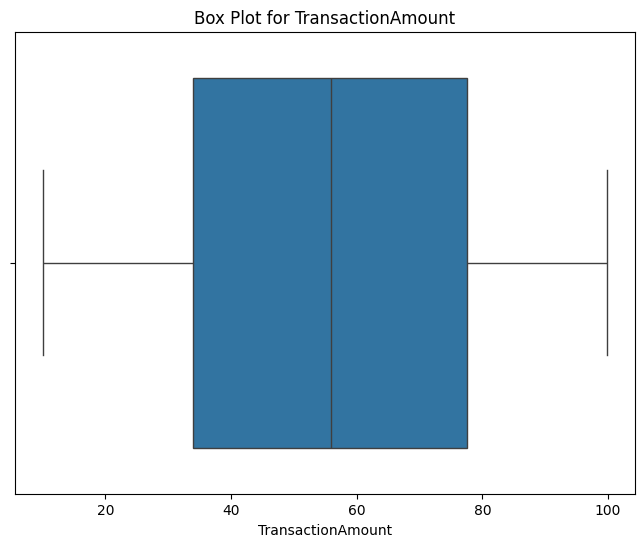

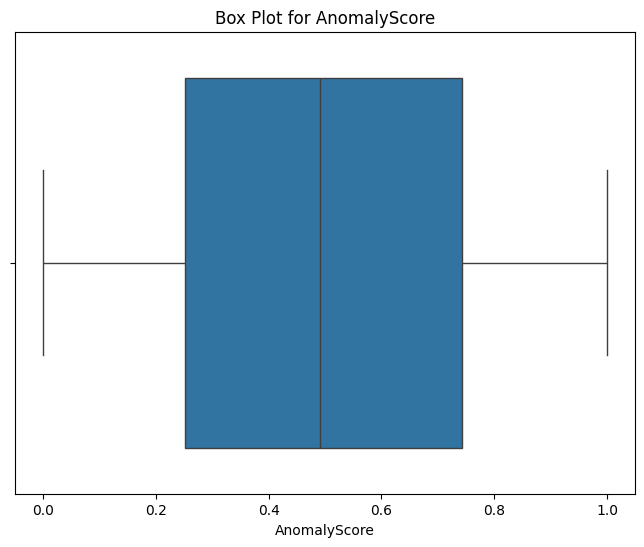

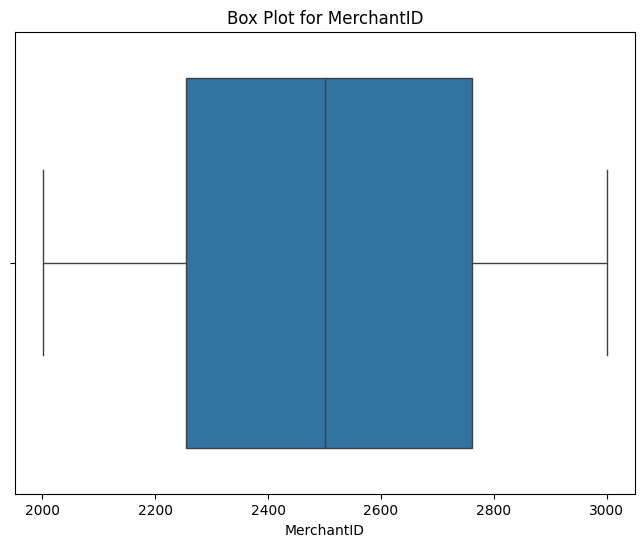

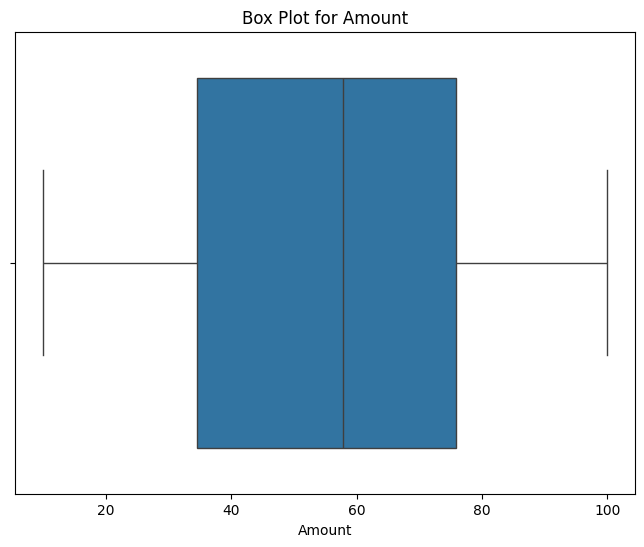

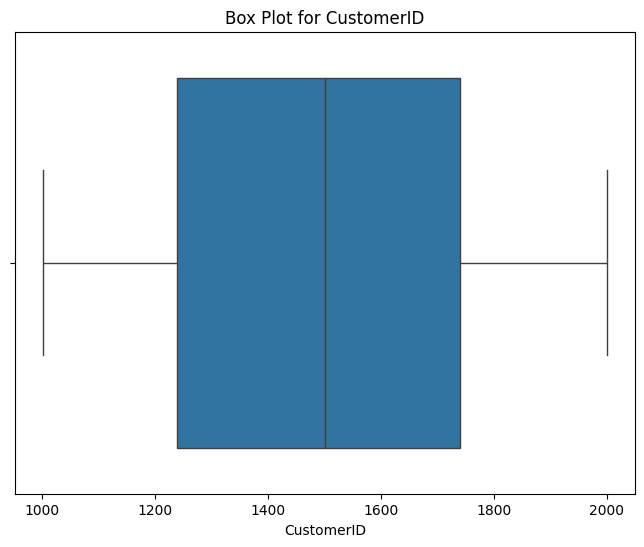

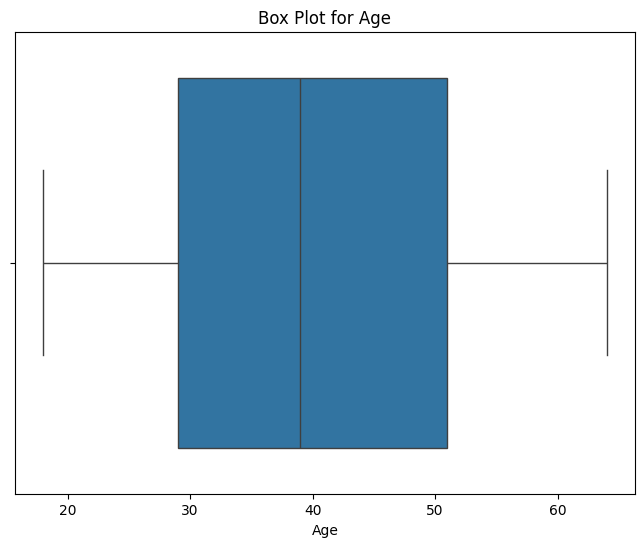

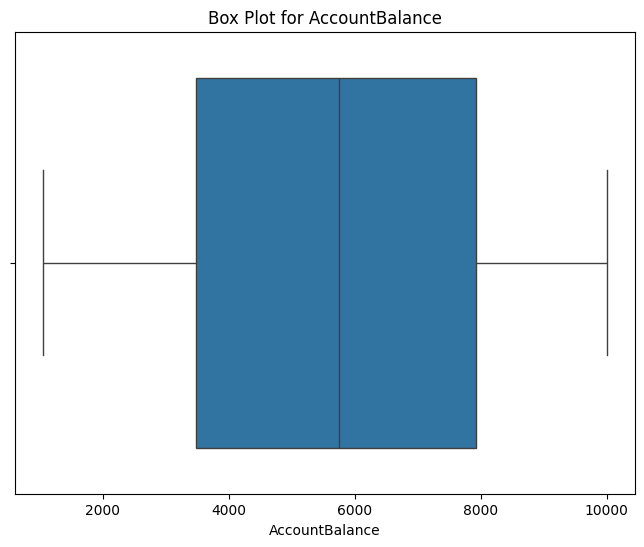

In [ ]:
# Quick overview of the dataset
print("Dataset Overview:")
print(data.info())

# Summary statistics
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Analyze class distribution for FraudIndicator
plt.figure(figsize=(8, 6))
sns.countplot(x='FraudIndicator', data=data, palette='Set2')
plt.title('Class Distribution of Fraud Indicator')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()

# Check correlations for numeric columns
correlation_matrix = data.select_dtypes(include=['number']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numeric Columns')
plt.show()

# Box plots for numerical features
num_cols = data.select_dtypes(include=['number']).columns
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot for {col}')
    plt.show()

# Data Preprocessing and Feature Engineering

In [ ]:
# Remove columns with missing data > 20%
missing_data_threshold = 20.0
missing_percentage = data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > missing_data_threshold].index.tolist()
data = data.drop(columns=columns_to_drop)
print(f"Dropped columns with missing data > {missing_data_threshold}%: {columns_to_drop}")

# Drop `TotalFraudulentTransaction` to prevent data leakage
if 'TotalFraudulentTransaction' in data.columns:
    data = data.drop(columns=['TotalFraudulentTransaction'])
    print("Removed 'TotalFraudulentTransaction' to prevent data leakage.")

# Impute missing values
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
data[numeric_columns] = SimpleImputer(strategy='mean').fit_transform(data[numeric_columns])

# Impute categorical columns with the most frequent value
if len(categorical_columns) > 0:
    data[categorical_columns] = SimpleImputer(strategy='most_frequent').fit_transform(data[categorical_columns])

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
print(f"Encoded categorical columns: {categorical_columns}")

# Feature scaling
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Define target and features
X = data.drop(columns=['FraudIndicator'], errors='ignore')
y = data['FraudIndicator']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Class distribution after SMOTE: {y_resampled.value_counts()}")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Dropped columns with missing data > 20.0%: []
Encoded categorical columns: Index([], dtype='object')
Class distribution after SMOTE: FraudIndicator
0.0    955
1.0    955
Name: count, dtype: int64
Training set shape: (1528, 13), Test set shape: (382, 13)


# Model and Feature Importance

In [ ]:
# Initialize models
logistic_model = LogisticRegression(random_state=42, max_iter=500)
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train models
logistic_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)

# Predict with Logistic Regression
y_pred_logistic = logistic_model.predict(X_test)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Predict with Random Forest
y_pred_rf = random_forest_model.predict(X_test)
y_prob_rf = random_forest_model.predict_proba(X_test)[:, 1]

# Predict with XGBoost
y_pred_xgb = xgboost_model.predict(X_test)
y_prob_xgb = xgboost_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
print("Logistic Regression Performance:")
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_logistic))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("--------------------------------------------------")

# Evaluate Random Forest
print("Random Forest Performance:")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("--------------------------------------------------")

# Evaluate XGBoost
print("XGBoost Performance:")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Logistic Regression Performance:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.57      0.56       192
         1.0       0.54      0.51      0.52       190

    accuracy                           0.54       382
   macro avg       0.54      0.54      0.54       382
weighted avg       0.54      0.54      0.54       382

ROC-AUC Score: 0.6245614035087719
Confusion Matrix:
[[110  82]
 [ 94  96]]
--------------------------------------------------
Random Forest Performance:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       192
         1.0       0.94      0.97      0.95       190

    accuracy                           0.95       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382

ROC-AUC Score: 0.9922149122807018
Confusion Matrix:
[[180  12]
 [  6 184]]
---------------------------------------

### 1. Logistic Regression Performance
- **Accuracy:** 54%
- **Precision (Weighted Average):** 54%
- **Recall (Weighted Average):** 54%
- **F1-Score (Weighted Average):** 54%
- **ROC-AUC Score:** 0.62

**Observations:**
- The Logistic Regression model struggles to distinguish between fraudulent (class 1) and non-fraudulent (class 0) transactions.
- Precision and recall are balanced but low, indicating limited predictive capability.
- The ROC-AUC score (0.62) suggests that the model has some discriminatory power but is not highly effective.

### 2. Random Forest Performance
- **Accuracy:** 95%
- **Precision (Weighted Average):** 95%
- **Recall (Weighted Average):** 95%
- **F1-Score (Weighted Average):** 95%
- **ROC-AUC Score:** 0.99

**Observations:**
- The Random Forest model performs significantly better than Logistic Regression, with high precision, recall, and F1-scores across both classes.
- The confusion matrix shows that the model correctly predicts a majority of instances, with only minimal false positives and false negatives.
- The ROC-AUC score (0.99) indicates that the model is highly effective at separating the classes.

### 3. XGBoost Performance
- **Accuracy:** 96%
- **Precision (Weighted Average):** 96%
- **Recall (Weighted Average):** 96%
- **F1-Score (Weighted Average):** 96%
- **ROC-AUC Score:** 0.99

**Observations:**
- XGBoost achieves similar performance to Random Forest, with slightly higher accuracy and ROC-AUC score.
- The confusion matrix highlights minimal misclassifications, with excellent precision and recall across both classes.
- This model is likely the best among the three for this dataset, given its slight edge over Random Forest.


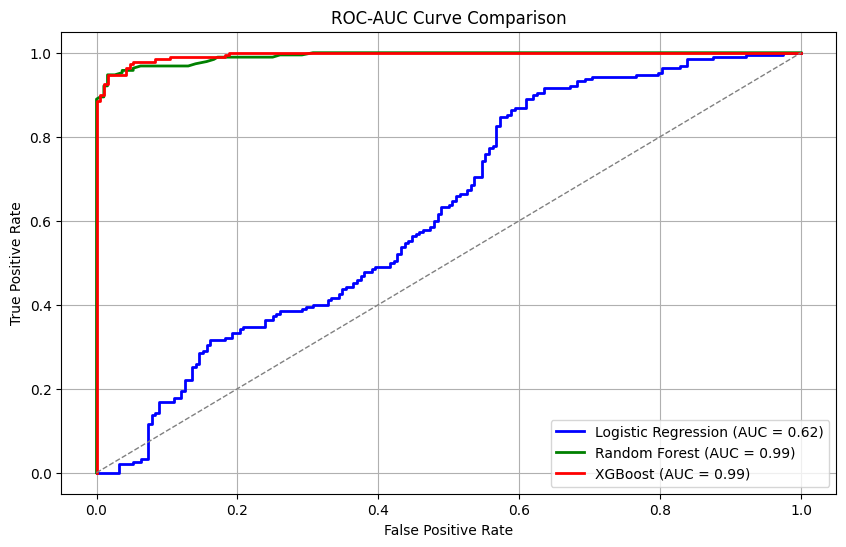

In [ ]:
# ROC-AUC Visualization
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## ROC-AUC Curve Analysis

### Key Observations:
1. **Logistic Regression:**
   - The blue curve indicates that Logistic Regression has poor separation capability between the classes.
   - Its AUC value of 0.62 reflects limited discriminatory power.

2. **Random Forest:**
   - The green curve is almost perfect, closely hugging the top-left corner of the plot, signifying excellent classification performance.
   - AUC = 0.99 demonstrates that the model effectively separates fraudulent from non-fraudulent transactions.

3. **XGBoost:**
   - The red curve overlaps with the green curve for most of the range, indicating similar performance to Random Forest.
   - AUC = 0.99 shows its strong classification ability.



Feature Importance Analysis for XGBoost:
              Feature  Importance
1            Category    0.259286
6          CustomerID    0.129896
12            TimeGap    0.087581
3        AnomalyScore    0.085788
10     AccountBalance    0.081801
2   TransactionAmount    0.081201
0       TransactionID    0.075967
5              Amount    0.058830
8                 Age    0.058361
4          MerchantID    0.051456
7                Name    0.029833
9             Address    0.000000
11    TransactionHour    0.000000


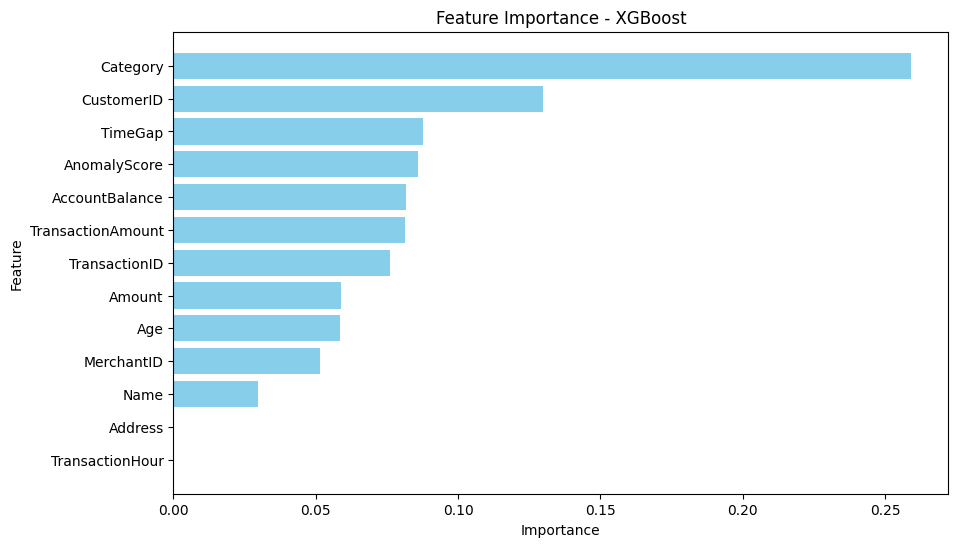

In [ ]:
# Feature Importance Analysis
print("\nFeature Importance Analysis for XGBoost:")
feature_importances = xgboost_model.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

## Feature Importance Analysis - XGBoost

### Key Observations:
1. **Top Features:**
   - **Category:** The most important feature with the highest importance score. This suggests that the type or category of the transaction is highly indicative of fraud.
   - **CustomerID:** A strong predictor, possibly reflecting patterns in customer behavior or transaction history that correlate with fraud.

2. **Moderately Important Features:**
   - **TimeGap:** Time-related features, such as the gap between transactions, are significant in identifying unusual patterns.
   - **AnomalyScore:** As expected, this feature plays a critical role in flagging transactions with abnormal characteristics.
   - **AccountBalance and TransactionAmount:** Financial metrics are key indicators, especially when deviations occur.

3. **Lower Importance Features:**
   - **Age, MerchantID, and TransactionHour:** While less critical, these features might still contribute by capturing subtle patterns.
   - **Name and Address:** These customer-specific attributes have minimal importance, likely because they are not directly linked to fraud detection.